# LAB 2: Recommender System from Scratch

Giorgio Lazzarinetti - My Contacts
For any questions or doubts you can find my contacts here:

giorgiolazzarinetti@gmail.com g.lazzarinetti@campus.unimib.it

## Notebook Outline

- **Introduction to Recommender System**
- **Movielens Dataset**
- **Generalized Matrix Factorization Model**
- **Neural Collaborative Filtering**
- **LAB CHALLENGE 1: Neural Matrix Factorization**

## References

The architecture of the deep model, the evaluation strategy and the metrics used are taken from the paper: ["Neural Collaborative Filtering"](https://arxiv.org/abs/1708.05031) by He Xiangnan, Liao Lizi, Zhang Hanwang, Nie Liqiang, Hu Xia and Chua Tat-Seng - In Porc. of the 26th Interantional Conference on World Wide Web - 2017.

## Introduction to Recommender System

Recommender systems are algorithms that mimic the psychology and personality of humans, in order to predict their needs and desires. More formally, recommender systems adopt data-mining and machine-learning techniques to help users in finding attractive and useful products. Products can be almost anything: physical items (e.g., smartphones), places (e.g., restaurants), digital content (e.g., movies and music), and many more. Recommender systems produce recommendations based on different inputs: demographic information about users, ratings and comments on products, individual’s or community’s past preferences and choices, social networks, context of use.

There are many different types of techniques and implementations out there.

- **Content-based methods** uses attributes of items to recommend to users new items similar to what the user has liked in the past (doesn't take into account the behaviour of other users);
- **Collaborative Filtering methods** uses similarities between users and items simultaneously to determine recommendations;
- **Hybrid methos** mix content-based and collaborative filtering approaches.

Other approaches are also called **Knowlege-based methods** which uses explicit knowledge about users and items to build recommendations criteria with a rule-based approach.


<center>  <img src="https://drive.google.com/uc?export=view&id=1Qaizz9YLvqgXg0blWFwN92IQSQPLTSoH" width="950" height="400"> </center>


In the following we'll focus on Collaborative Filtering methods, with a model-based approach with deep learning algorithms.

### Problem Definition

Given a past record of movies seen by a user, we will build a recommender system that helps the user discover movies of their interest.

Specifically, given <userID, itemID> occurrence pairs, we need to generate a ranked list of movies for each user.

We model the problem as a binary classification problem, where we learn a function to predict whether a particular user will like a particular movie or not.

$$f(userid, itemid) →, [0,1]$$

The model takes in two sparse vectors, one representing the user and the other represents items. The users vector has size #users, while the items vector has size #items.  

So, elaborately,
- User vector=[0,0,1...,0,0,0] with m elements, means this vector represents the 3 rd user out of m.
- Item vector=[0,1,0,0,0,0...0] with n elements, means this vector represents the 2 nd item out of n.

Basically both items and users are one-hot encoded.

These two vectors should be passed to a first embedding layer  (to project sparse representations to dense ones). These embeddings can be seen as a latent vector for users and items.

Thus, the final predictive model will be
$$y_{ui} = f(\mathbf{P}^T\mathbf{v}_u^T, \mathbf{Q}^T\mathbf{v}_i^T | \mathbf{P}, \mathbf{Q}, \mathbf{\Theta}_f) $$

where **P** and **Q** denotes the latent factor matrix for users and items and **$\Theta_f$** denotes the model parameters.


### Packages

In [ ]:
import os
import time
import random
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

In [67]:
np.random.seed(7)
torch.manual_seed(0)

In [68]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [18]:
#/kaggle/input/u-data/u.data

## Movielens Dataset

### Dataset

We use the MovieLens 100K dataset, which has 100,000 ratings from 1000 users on 1700 movies.

The ratings are given to us in form of <userID,itemID, rating, timestamp> tuples. Each user has a minimum of 20 ratings.

You can download the dataset [here](https://grouplens.org/datasets/movielens/). Download the file ml-100k.zip. Unzip it and extract the file u.data

### Create Dataset

Here we are going to create the necessary dataset for building recommender system.

After downloading the file as indicated, save them in your Colab Notebooks directory. In order to let the Notebook see the file on your Drive you have to mount it.

In [69]:
dataset_origin = {'100k': 'u.data', '1M': 'ratings.dat'}

num_sample_data = '100k'
DATA_PATH = '/kaggle/input/u-data/{}'.format(dataset_origin[num_sample_data]) #change this with your directory
MODEL_PATH = '/kaggle/input{}/'.format(num_sample_data) #change this with your directory


We now build some function to manage the data.

We drop the exact value of rating (1,2,3,4,5) and instead convert it to an implicit scenario i.e. any positive interaction is given value of 1. All other interactions are given a value of zero, by default.

Since we are training a classifier, we need both positive and negative samples. The records present in the dataset are counted as positive samples. We assume that all entries in the user-item interaction matrix are negative samples (a strong assumption, and easy to implement).

We randomly sample 4 items that are not interacted by the user, for every item interacted by the user. This way, if a user has 20 positive interactions, he will have 80 negative interactions. These negative interactions cannot contain any positive interaction by the user, though they may not be all unique due to random sampling.

We now define the class MovieLens Dataset which will be used do read the data and create the train and test dataset.

In [70]:
class Rating_Datset(Dataset):
	def __init__(self, user_list, item_list, rating_list):
		super(Rating_Datset, self).__init__()
		self.user_list = user_list
		self.item_list = item_list
		self.rating_list = rating_list

	def __len__(self):
		return len(self.user_list)

	def __getitem__(self, idx):
		user = self.user_list[idx]
		item = self.item_list[idx]
		rating = self.rating_list[idx]

		return (
			torch.tensor(user, dtype=torch.long),
			torch.tensor(item, dtype=torch.long),
			torch.tensor(rating, dtype=torch.float)
			)

In [71]:
class NCF_Data(object):
	"""
	Construct Dataset for NCF
	"""
	def __init__(self, args, ratings):
		self.ratings = ratings
		self.num_ng = args.num_ng
		self.num_ng_test = args.num_ng_test
		self.batch_size = args.batch_size

		self.preprocess_ratings = self._reindex(self.ratings)

		self.user_pool = set(self.ratings['user_id'].unique())
		self.item_pool = set(self.ratings['item_id'].unique())

		self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
		self.negatives = self._negative_sampling(self.preprocess_ratings)


	def _reindex(self, ratings):
		"""
		Process dataset to reindex userID and itemID, also set rating as binary feedback
		"""
		user_list = list(ratings['user_id'].drop_duplicates())
		user2id = {w: i for i, w in enumerate(user_list)}

		item_list = list(ratings['item_id'].drop_duplicates())
		item2id = {w: i for i, w in enumerate(item_list)}

		ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
		ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
		ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
		return ratings

	def _leave_one_out(self, ratings):
		"""
		leave-one-out evaluation protocol in paper https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
		"""
		ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
		test = ratings.loc[ratings['rank_latest'] == 1]
		train = ratings.loc[ratings['rank_latest'] > 1]
		assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
		return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]

	def _negative_sampling(self, ratings):
		interact_status = (
			ratings.groupby('user_id')['item_id']
			.apply(set)
			.reset_index()
			.rename(columns={'item_id': 'interacted_items'}))
		interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
		interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
		return interact_status[['user_id', 'negative_items', 'negative_samples']]

	def get_train_instance(self):
		users, items, ratings = [], [], []
		train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
		train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
		for row in train_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in range(self.num_ng):
				users.append(int(row.user_id))
				items.append(int(row.negatives[i]))
				ratings.append(float(0))  # negative samples get 0 rating
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

	def get_test_instance(self):
		users, items, ratings = [], [], []
		test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
		for row in test_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in getattr(row, 'negative_samples'):
				users.append(int(row.user_id))
				items.append(int(i))
				ratings.append(float(0))
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=2)

### Evaluation Metrics

We randomly sample 100 items that are not interacted by the user, ranking the test item among the 100 items. We truncate the ranked list at 10.

Since it is too time-consuming to rank all items for every user, for we will have to calculate 1000\*1700 ~10⁶ values. With this strategy, we need 1000*100 ~ 10⁵ values, an order of magnitude less.

For each user, we use the latest rating(according to timestamp) in the test set, and we use the rest for training. This evaluation methodology is also known as leave-one-out strategy.

#### Metrics

We use **Hit Ratio** (HR), and **Normalized Discounted Cumulative Gain** (NDCG) to evaluate the performance for our RS.


In recommender settings, the **HR** is simply the fraction of users for which the correct answer is included in the recommendation list of length L.

$$HR = \frac{|U_{hit}^{L}|}{U_{all}}$$

Where $U_{hit}^{L}$ is the number of users for which the correct answer is included in the top L recommendation list, while, $U_{all}$ is the total number of user in the test dataset. Clearly the larger L is the larger HR become.

**NDCG** is a measure of ranking quality. In information retrieval, it is often used to measure effectiveness of web search engine algorithms or related applications. Using a graded relevance scale of documents in a search-engine result set, DCG measures the usefulness, or gain, of a document based on its position in the result list. The gain is accumulated from the top of the result list to the bottom, with the gain of each result discounted at lower ranks

**Gain** for an item is essentialy the same as the relevance score, which can be numerical ratings like search results in Google which can be rated in scale from 1 to 5, or binary in case of implicit data where we only know if a user has consumed certain item or not. Naturally **Cumulative Gain** is defined as the sum of gains up to a position k in the recommendation list.

$$CG(k) = \sum_{i=1}^{k}G_i$$

One obvious drawback of CG is that it does not take into account of ordering. By swapping the relative order of any two items, the CG would be unaffected. This is problematic when ranking order is important. For example, on Google Search results, you would obviously not like placing the most relevant web page at the bottom.

To penalize highly relevant items being placed at the bottom, we introduce the **Discounted Cumulative Gaing** (DCG).

$$DCG(k) = \sum_{i=1}^{k} \frac{G_i}{log_2(i+1)}$$

By diving the gain by its rank, we sort of push the algorithm to place highly relevant items to the top to achieve the best DCG score.

There is still a drawback of DCG score. It is that DCG score adds up with the length of recommendation list. Therefore, we cannot consistently compare the DCG score for system recommending top 5 and top 10 items, because the latter will have higher score not because its recommendation quality but pure length.

We tackle this issue by introducing **Ideal Discounted Cumulative Gain** (IDCG). IDCG is the DCG score for the most ideal ranking, which is ranking the items top down according their relevance up to position k.

$$IDCG(k) = \sum_{i=1}^{|I(k)|} \frac{G_i}{log_2(i+1)}$$

Where $|I(k)|$ represent the ideal list of items up to position k.

And NDCG is simply to normalize the DCG score by IDCG such that its value is always between 0 and 1 regardless of the length.

$$NDCD(k) = \frac{DCG(k)}{IDCG(k)}$$

Our model gives a confidence score between 0 and 1 for each item present in the test set for a given user. The items are sorted in decreasing order of their score, and top 10 items are given as recommendation. If the test item (which is only one for each user) is present in this list, HR is one for this user, else it is zero. The final HR is reported after averaging for all users. A similar calculation is done for NDCG.

While training, we will be minimizing the cross-entropy loss, which is the standard loss function for a classification problem. The real strength of RS lies in giving a ranked list of top-k items, which a user is most likely to interact. Think about why you mostly click on google search results only on the first page, and never go to other pages. Metrics like NDCG and HR help in capturing this phenomenon by indicating the quality of our ranked lists.

In [72]:
def hit(ng_item, pred_items):
	if ng_item in pred_items:
		return 1
	return 0


def ndcg(ng_item, pred_items):
	if ng_item in pred_items:
		index = pred_items.index(ng_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k, device):
	HR, NDCG = [], []

	for user, item, label in test_loader:
		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)
		_, indices = torch.topk(predictions, top_k)
		recommends = torch.take(
				item, indices).cpu().numpy().tolist()

		ng_item = item[0].item() # leave one-out evaluation has only one item per user
		HR.append(hit(ng_item, recommends))
		NDCG.append(ndcg(ng_item, recommends))

	return np.mean(HR), np.mean(NDCG)

## Generalized Matrix Factorization (GMF)

Generally Matrix Factorization (MF) algorithms associates each user and item with a real-valued vector of latent features.

Let $\mathbf{p_u}$ and $\mathbf{q_i}$ denote the latent vector for user u and item i, respectively; MF estimates an interaction y_{ui} as the inner product of $\mathbf{p_u}$ and $\mathbf{q_i}$:

$$y_{ui} = f(u, i| \mathbf{p_u}, \mathbf{q_i}) = \mathbf{p_u}^T\mathbf{q_i} = \sum_{k=1}^Kp_{uk}q_{ik} $$

Where K denotes the dimension of the latent space.

MF models the dimension of the interaction of user and item latent factors, assuming each dimension of the latent space is independent of each other and linearly combining them  with the same weights.

This imposes some limitation of MF caused by the use of a simple and fixed inner product to estimate complex user-item interactions in the low-dimensional latent space.

In order to overcome this limitation, we can build a Generalized Matrix Factorization (GMF) algorithm where we can weight the linear combination of the element-wise product and use this with an activation function to learn a representation of the input insted of using a fixed one.

Let the user latent vector $\mathbf{p_u}$  be denoted as $\mathbf{P}^T\mathbf{v}_u^T$ and the item latent vector $\mathbf{q_i}$ as $\mathbf{Q}^T\mathbf{v}_i^T$.

The GMF can be expressed as
$$Y_{ui} = a_{out}(\mathbf{h}^T(\mathbf{p_u}\odot \mathbf{q_i})$$
where $a_{out}$ is the activation function and $\mathbf{h}$ are the edge weights of the output layer.

Intuitively, if we use an identity function as $a_{out}$ and enforce $\mathbf{h}$ to be a uniform vector of 1, we can exactly recover the MF model.

In the following we will use $\mathbf{h}$ as linear layer and a $a_{out}$ as sigmoid function to learn $\mathbf{h}$ weigths from data with the log loss.



In [390]:
class GMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.affine_output = nn.Linear(in_features=self.factor_num, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating.squeeze()

    def init_weight(self):
        pass

## Neural Collaborative Filtering
GMF learn user and item embedding separately. To empower the model it is possible to combine the features of two pathways by concatenating them and passing this concatenation to a Multi-Layer Perceptron (MLP) to learn the interaction between user and item latent features. This model is known as Neural Collaborative Filtering (NCF)

The input to the model is userID and itemID, which is fed into an embedding layer. Thus, each user and item is given an embedding. Then there are multiple dense layers afterward, followed by a single neuron with a sigmoid activation.

The output of the sigmoid neuron can be interpreted as the probability the user is likely to interact with an item.

The model, we are going to implement is the following:
<center>  <img src="https://drive.google.com/uc?export=view&id=1rL_8kkHIhSlQjWr8hNal4Tyog87-2kNP" width="550" height="350"> </center>

The user in item vectors are passed to an embedding layer that build a dense or latent vectors for the sparse inputs, from the input layer. The obtained latent vectors are fed into the multi-layer neural architecture, to map the latent vectors to the predicted probability scores. The layers are responsible to find the complex user-item relations from the data.

The output layer produces the predicted score $y_(ui)$, i.e, how much is the probability that the user u will interact with the item i.

A pointwise loss function is used to minimize the difference between the target value Y(ui) and the corresponding predicted value.

Formally the model we are going to implement is the following:

$$\mathbf{z_1} = \phi_1 (\mathbf{p_u}, \mathbf{q_i}) = \begin{bmatrix}
\mathbf{p_u} \\ \mathbf{q_i}
\end{bmatrix}$$

$$\phi_L(\mathbf{z}_{L-1}) = a_L(\mathbf{W}_L^T\mathbf{z}_{L-1} + \mathbf{b}_L)$$

$$ y_{ui} = \sigma(\mathbf{h}^T\phi_L(\mathbf{z}_{L-1}))$$

where $\mathbf{W}_x, \mathbf{b}_x, a_x$ denotes the weight matrix, bias vector and activation function for the x-th layer's perceptron


In [391]:
class MLP(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        self.layers = args.layers

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
            # vector = nn.BatchNorm1d()(vector)
            # vector = nn.Dropout(p=0.5)(vector)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()

    def init_weight(self):
        pass

In [392]:
#collapse-hide
parser = argparse.ArgumentParser()
parser.add_argument("--seed",
	type=int,
	default=42,
	help="Seed")
parser.add_argument("--lr",
	type=float,
	default=0.001,
	help="learning rate")
parser.add_argument("--dropout",
	type=float,
	default=0.2,
	help="dropout rate")
parser.add_argument("--batch_size",
	type=int,
	default=256,
	help="batch size for training")
parser.add_argument("--epochs",
	type=int,
	default=30,
	help="training epoches")
parser.add_argument("--top_k",
	type=int,
	default=10,
	help="compute metrics@top_k")
parser.add_argument("--factor_num",
	type=int,
	default=32,
	help="predictive factors numbers in the model")
parser.add_argument("--layers",
    nargs='+',
    default=[64,32,16,8],
    help="MLP layers. Note that the first layer is the concatenation of user \
    and item embeddings. So layers[0]/2 is the embedding size.")
parser.add_argument("--num_ng",
	type=int,
	default=4,
	help="Number of negative samples for training set")
parser.add_argument("--num_ng_test",
	type=int,
	default=100,
	help="Number of negative samples for test set")
parser.add_argument("--out",
	default=True,
	help="save model or not")

_StoreAction(option_strings=['--out'], dest='out', nargs=None, const=None, default=True, type=None, choices=None, required=False, help='save model or not', metavar=None)

In [177]:
args=parser.parse_args("")
print(args)

Namespace(seed=42, lr=0.001, dropout=0.2, batch_size=256, epochs=30, top_k=10, factor_num=64, layers=[64, 32, 16, 8], num_ng=4, num_ng_test=100, out=True)


In [110]:
#model_GMF = torch.load('/kaggle/input100k/GMF.pt')

In [47]:
model_GMF

GMF(
  (embedding_user): Embedding(944, 64)
  (embedding_item): Embedding(1683, 64)
  (affine_output): Linear(in_features=64, out_features=1, bias=True)
  (logistic): Sigmoid()
)

In [28]:
model_GMF

GMF(
  (embedding_user): Embedding(944, 32)
  (embedding_item): Embedding(1683, 32)
  (affine_output): Linear(in_features=32, out_features=1, bias=True)
  (logistic): Sigmoid()
)

In [6]:
ml_100k = pd.read_csv(
	DATA_PATH,
	sep="\t",
	names = ['user_id', 'item_id', 'rating', 'timestamp'],
	engine='python')

In [13]:
ml_100k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [10]:
ml_100k.describe()

,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [41]:
model_MLP = torch.load('/kaggle/input100k/MLP.pt')

In [38]:
model_MLP

MLP(
  (embedding_user): Embedding(944, 32)
  (embedding_item): Embedding(1683, 32)
  (fc_layers): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=8, out_features=1, bias=True)
  (logistic): Sigmoid()
)

## LAB CHALLENGE: Neural Matrix Factorization
So far we have developed GMF that applies a linear kernel to model the latent feature interactions and MLP that uses a non-linear kernel to learn the interaction function from data.

How can we fuse GMF and MLP under the NCF framework, so that they can mutually reinforce each other to better model the complex user-item interactions?

A straightforward solution is to let GMF and MLP share the same embedding layer and then combine the outputs of their interaction functions.

To provide flexibility to the fused model we want to allow GMF and MLP to learn separate embeddings and combine two models by concatenating their last hidden layer.

Formally

$$\phi^{GMF} = \mathbf{p_u}^G\odot \mathbf{q_i}^G$$
$$\phi^{MLP} = a_L(\mathbf{W}_L^T(a_{L-1}(...a_2 (\mathbf{W}_2^T \begin{bmatrix}
\mathbf{p_u} \\ \mathbf{q_i}
\end{bmatrix} + \mathbf{b}_2)...)) + \mathbf{b}_L)$$

$$ y_{ui} = \sigma(\mathbf{h}^T \begin{bmatrix}
\ \phi^{GMF} \\ \phi^{MLP}
\end{bmatrix})$$

that results in the following model architecture

<center>  <img src="https://drive.google.com/uc?export=view&id=1gNLUpiQdbDPMdvfZYVs3lcou3cd4Favb" width="550" height="400"> </center>


- TASK 1: implement the model as described
- TASK 2: compare the performance of such model with the GMS and MLP models using the metrics provided.
- TASK 3: tune the networks by plotting HR@10 and NDCG@10 with respect to the number of predictive factors [8, 16, 32, 64] for all the 3 algorithms


In [393]:
#TASK 1
#this the one this is using
class NeuMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num_mf = args.factor_num
        self.factor_num_mlp = args.layers[0] // 2
        self.layers = args.layers
        self.dropout = args.dropout

        # GMF part
        self.embedding_user_GMF = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mf)
        self.embedding_item_GMF = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mf)

        # MLP part
        self.embedding_user_MLP = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mlp)
        self.embedding_item_MLP = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mlp)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        # Output layer
        self.affine_output = nn.Linear(in_features=self.layers[-1] + self.factor_num_mf, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        # GMF
        user_embedding_GMF = self.embedding_user_GMF(user_indices)
        item_embedding_GMF = self.embedding_item_GMF(item_indices)
        vector_GMF = torch.mul(user_embedding_GMF, item_embedding_GMF)

        # MLP
        user_embedding_MLP = self.embedding_user_MLP(user_indices)
        item_embedding_MLP = self.embedding_item_MLP(item_indices)
        vector_MLP = torch.cat([user_embedding_MLP, item_embedding_MLP], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector_MLP = self.fc_layers[idx](vector_MLP)
            vector_MLP = nn.ReLU()(vector_MLP)
            vector_MLP = nn.Dropout(p=self.dropout)(vector_MLP)

        # Concatenate GMF and MLP vectors
        vector = torch.cat([vector_GMF, vector_MLP], dim=-1)

        # Output layer
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()

    def init_weight(self):
        pass


In [422]:
def TrainGMF(factor,epo,lay):
    # set device and parameters
    args = parser.parse_args("")
    args.layers=lay
    args.factor_num=factor
    args.epochs=epo
    #args.layers=lay
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


    list_HR=[]
    list_NDCG=[]
    # load data
    ml_100k = pd.read_csv(
        DATA_PATH,
        sep="\t",
        names = ['user_id', 'item_id', 'rating', 'timestamp'],
        engine='python')

    # set the num_users, items
    num_users = ml_100k['user_id'].nunique()+1
    num_items = ml_100k['item_id'].nunique()+1

    # construct the train and test datasets
    data = NCF_Data(args, ml_100k)
    train_loader = data.get_train_instance()
    test_loader = data.get_test_instance()

    # set model and loss, optimizer
    model = GMF(args, num_users, num_items)
    model = model.to(device)
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # train, evaluation
    best_hr = 0
    for epoch in range(1, args.epochs+1):
        model.train() # Enable dropout (if have).
        start_time = time.time()

        for user, item, label in train_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            prediction = model(user, item)
            loss = loss_function(prediction, label)
            loss.backward()
            optimizer.step()
            #writer.add_scalar('loss/Train_loss', loss.item(), epoch)

        model.eval()
        HR, NDCG = metrics(model, test_loader, args.top_k, device)
        #writer.add_scalar('Perfomance/HR@10', HR, epoch)
        #writer.add_scalar('Perfomance/NDCG@10', NDCG, epoch)

        elapsed_time = time.time() - start_time
        #print("GMF=================================================================GMF")
        #print("Epoch {:03d}".format(epoch) + " time to train: " +
            #time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
        #print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))
        list_HR.append(np.mean(HR))
        list_NDCG.append(np.mean(NDCG))
        #print("this is HR****************************",list_HR)
        #print("this is NDCG****************************",list_NDCG)

        if HR > best_hr:
            best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
            if args.out:
                if not os.path.exists(MODEL_PATH):
                    os.mkdir(MODEL_PATH)
                torch.save(model,
                    '{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))
    return list_HR,list_NDCG

     

In [423]:
def TrainMLP(factor,epo,lay):
    # set device and parameters
    args = parser.parse_args("")
    args.layers=lay
    args.factor_num=factor
    args.epochs=epo
    #args.layers=lay
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


    list_HR=[]
    list_NDCG=[]
    # load data
    ml_100k = pd.read_csv(
        DATA_PATH,
        sep="\t",
        names = ['user_id', 'item_id', 'rating', 'timestamp'],
        engine='python')

    # set the num_users, items
    num_users = ml_100k['user_id'].nunique()+1
    num_items = ml_100k['item_id'].nunique()+1

    # construct the train and test datasets
    data = NCF_Data(args, ml_100k)
    train_loader = data.get_train_instance()
    test_loader = data.get_test_instance()

    # set model and loss, optimizer
    model = MLP(args, num_users, num_items)
    model = model.to(device)
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # train, evaluation
    best_hr = 0
    for epoch in range(1, args.epochs+1):
        model.train() # Enable dropout (if have).
        start_time = time.time()

        for user, item, label in train_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            prediction = model(user, item)
            loss = loss_function(prediction, label)
            loss.backward()
            optimizer.step()
            #writer.add_scalar('loss/Train_loss', loss.item(), epoch)

        model.eval()
        HR, NDCG = metrics(model, test_loader, args.top_k, device)
        #writer.add_scalar('Perfomance/HR@10', HR, epoch)
        #writer.add_scalar('Perfomance/NDCG@10', NDCG, epoch)

        elapsed_time = time.time() - start_time
        #print("MLP=================================================================MLP")
       # print("Epoch {:03d}".format(epoch) + " time to train: " +
          #  time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
        #print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))
        list_HR.append(np.mean(HR))
        list_NDCG.append(np.mean(NDCG))
        #print("this is HR****************************",list_HR)
        #print("this is NDCG****************************",list_NDCG)

        if HR > best_hr:
            best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
            if args.out:
                if not os.path.exists(MODEL_PATH):
                    os.mkdir(MODEL_PATH)
                torch.save(model,
                    '{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))
    return list_HR,list_NDCG

In [424]:
def TrainNeuMF(factor,epo,lay):
    # set device and parameters
    args = parser.parse_args("")
    args.layers=lay
    args.factor_num=factor
    args.epochs=epo
    #args.layers=lay
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


    list_HR=[]
    list_NDCG=[]
    # load data
    ml_100k = pd.read_csv(
        DATA_PATH,
        sep="\t",
        names = ['user_id', 'item_id', 'rating', 'timestamp'],
        engine='python')

    # set the num_users, items
    num_users = ml_100k['user_id'].nunique()+1
    num_items = ml_100k['item_id'].nunique()+1

    # construct the train and test datasets
    data = NCF_Data(args, ml_100k)
    train_loader = data.get_train_instance()
    test_loader = data.get_test_instance()

    # set model and loss, optimizer
    model = NeuMF(args, num_users, num_items)
    model = model.to(device)
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # train, evaluation
    best_hr = 0
    for epoch in range(1, args.epochs+1):
        model.train() # Enable dropout (if have).
        start_time = time.time()

        for user, item, label in train_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            prediction = model(user, item)
            loss = loss_function(prediction, label)
            loss.backward()
            optimizer.step()
            #writer.add_scalar('loss/Train_loss', loss.item(), epoch)

        model.eval()
        HR, NDCG = metrics(model, test_loader, args.top_k, device)
        #writer.add_scalar('Perfomance/HR@10', HR, epoch)
        #writer.add_scalar('Perfomance/NDCG@10', NDCG, epoch)

        elapsed_time = time.time() - start_time
        #print("NEUMF=================================================================NeuMF")
        #print("Epoch {:03d}".format(epoch) + " time to train: " +
        #    time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
        #print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))
        list_HR.append(np.mean(HR))
        list_NDCG.append(np.mean(NDCG))
        #print("this is HR****************************",list_HR)
        #print("this is NDCG****************************",list_NDCG)

        if HR > best_hr:
            best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
            if args.out:
                if not os.path.exists(MODEL_PATH):
                    os.mkdir(MODEL_PATH)
                torch.save(model,
                    '{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))
    return list_HR,list_NDCG


In [ ]:
print(args)
factors_list = [8, 16, 32, 64]
factors_scores_hr_GMF={}
factors_scores_ndcg_gmf={}

factors_scores_hr_NeuM={}
factors_scores_ndcg_NeurMF={}


epo=30
#lay=[128,64,32,16]
lay=[64,32,16,8]
print(args)
for factor in factors_list:
    factors_scores_hr_GMF[factor],factors_scores_ndcg_gmf[factor]=TrainGMF(factor,epo=epo,lay=lay)
for factor in factors_list:
    factors_scores_hr_NeuM[factor],factors_scores_ndcg_NeurMF[factor]=TrainNeuMF(factor,epo=epo,lay=lay)
    

    

print(factors_scores_hr_GMF)
factors_scores_hr_GMF=factors_scores_hr_GMF

print(factors_scores_ndcg_gmf)
factors_scores_ndcg_gmf=factors_scores_ndcg_gmf





print(factors_scores_hr_NeuM)
factors_scores_hr_NeuM=factors_scores_hr_NeuM

print(factors_scores_ndcg_NeurMF)
factors_scores_ndcg_NeurMF=factors_scores_ndcg_NeurMF





In [ ]:


print(args)
factors_scores_hr_MLP={}
factors_scores_ndcg_MLP={}




epo=30
print(args)




#trainin MLP for factor 64   
factor=64
layers=[128,64,32,16]
factors_scores_hr_MLP_64,factors_scores_ndcg_MLP_64=TrainMLP(factor=64,epo=epo,lay=layers)



print(factors_scores_hr_MLP_64)
factors_scores_hr_MLP_64=factors_scores_hr_MLP_64

print(factors_scores_ndcg_MLP_64)
factors_scores_ndcg_MLP_64=factors_scores_ndcg_MLP_64

print("-----------------------------64 finish")


#trainin MLP for factor 32   
factor=32
layers=[64,32,16,8]
factors_scores_hr_MLP_32,factors_scores_ndcg_MLP_32=TrainMLP(factor=factor,epo=epo,lay=layers)



print(factors_scores_hr_MLP_32)
factors_scores_hr_MLP_32

print(factors_scores_ndcg_MLP_32)
factors_scores_ndcg_MLP_32
print("-----------------------------32 finish")


#trainin MLP for factor 16  
factor=16
layers=[32,16,8,4]
factors_scores_hr_MLP_16,factors_scores_ndcg_MLP_16=TrainMLP(factor=factor,epo=epo,lay=layers)



print(factors_scores_hr_MLP_16)
factors_scores_hr_MLP_16

print(factors_scores_ndcg_MLP_16)
factors_scores_ndcg_MLP_16

print("-----------------------------16 finish")

#trainin MLP for factor 8   
factor=8
layers=[16,8,4,2]
factors_scores_hr_MLP_8,factors_scores_ndcg_MLP_8=TrainMLP(factor=factor,epo=epo,lay=layers)



print(factors_scores_hr_MLP_8)
factors_scores_hr_MLP_8

print(factors_scores_ndcg_MLP_8)
factors_scores_ndcg_MLP_8

print("-----------------------------8 finish")



Namespace(seed=42, lr=0.001, dropout=0.2, batch_size=256, epochs=30, top_k=10, factor_num=64, layers=[64, 32, 16, 8], num_ng=4, num_ng_test=100, out=True)
Namespace(seed=42, lr=0.001, dropout=0.2, batch_size=256, epochs=30, top_k=10, factor_num=64, layers=[64, 32, 16, 8], num_ng=4, num_ng_test=100, out=True)


/tmp/ipykernel_34/3834424632.py:52: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
/tmp/ipykernel_34/3834424632.py:58: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))


[0.41145281018027574, 0.40402969247083775, 0.41251325556733826, 0.44220572640509015, 0.48462354188759277, 0.513255567338282, 0.5259809119830329, 0.5408271474019088, 0.5493107104984093, 0.5588547189819725, 0.559915164369035, 0.574761399787911, 0.5768822905620361, 0.574761399787911, 0.5927889713679746, 0.5726405090137858, 0.574761399787911, 0.5705196182396607, 0.5694591728525981, 0.584305408271474, 0.5758218451749735, 0.5832449628844114, 0.5705196182396607, 0.5874867444326617, 0.5779427359490986]
[0.2220372101853989, 0.22261261643992789, 0.23069743936685078, 0.24820094019782732, 0.2712700547072959, 0.29046139354709, 0.29380247463963927, 0.30444654164063795, 0.3081121486016476, 0.30987139876688313, 0.31162689850435904, 0.32765917536510525, 0.3206345718065638, 0.3207106621898653, 0.32857441077113836, 0.32245346609518105, 0.3190010780036417, 0.3282532861053065, 0.32430202810369213, 0.32589104142083325, 0.3227040823145546, 0.3238797276428864, 0.3217652476245553, 0.3298249067534794, 0.3241596

/tmp/ipykernel_34/3834424632.py:52: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
/tmp/ipykernel_34/3834424632.py:58: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))


[0.4146341463414634, 0.4135737009544008, 0.41993637327677624, 0.42311770943796395, 0.4188759278897137, 0.42629904559915166, 0.4411452810180276, 0.45068928950159065, 0.4687168610816543, 0.48568398727465534, 0.5026511134676565, 0.5079533404029692, 0.5302226935312832, 0.5334040296924708, 0.5471898197242842, 0.5482502651113468, 0.5588547189819725, 0.5694591728525981, 0.5567338282078473, 0.5694591728525981, 0.559915164369035, 0.5556733828207847, 0.5683987274655355, 0.5620360551431601, 0.5673382820784729]
[0.22115825616165358, 0.22035835581201244, 0.22145148521258645, 0.22179852663563465, 0.22351333843059884, 0.23066640536541888, 0.24057459406301188, 0.25080730662865475, 0.2584342490572622, 0.26794534049943813, 0.2788589238251503, 0.28579098937556957, 0.29040854648243675, 0.2950550885588914, 0.2993907604793657, 0.3044291064523463, 0.3071699843595565, 0.3134177960911778, 0.30883685330126937, 0.31001415514260966, 0.3049717815651543, 0.3046253348478195, 0.30681194019200286, 0.3071889814580798, 

/tmp/ipykernel_34/3834424632.py:52: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
/tmp/ipykernel_34/3834424632.py:58: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))


[0.3934252386002121, 0.3944856839872747, 0.39660657476139977, 0.4029692470837752, 0.4019088016967126, 0.4146341463414634, 0.4209968186638388, 0.42735949098621423, 0.4443266171792153, 0.4559915164369035, 0.4676564156945917, 0.47932131495228, 0.4941675503711559, 0.49628844114528103, 0.49522799575821846, 0.5005302226935313, 0.5047720042417816, 0.5058324496288441, 0.503711558854719, 0.5143160127253447, 0.5153764581124072, 0.5227995758218452, 0.5344644750795334, 0.5249204665959704, 0.5174973488865323]
[0.20656456506218548, 0.21640316310978241, 0.2176345619473022, 0.2194946513017961, 0.21734920862122417, 0.2255399918255817, 0.22895012055118502, 0.23592845228752438, 0.24619346735068995, 0.2562690784817112, 0.26176341083947596, 0.2682525505512554, 0.2738635287960232, 0.27587870806670134, 0.2804584529163429, 0.2805590346009433, 0.2807048688791558, 0.2826537627480745, 0.28329417890946024, 0.28570055413550177, 0.2838489564980512, 0.288490650925261, 0.29132153819001316, 0.2894347315539654, 0.28620

/tmp/ipykernel_34/3834424632.py:52: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
/tmp/ipykernel_34/3834424632.py:58: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))


[0.4019088016967126, 0.3605514316012725, 0.4093319194061506, 0.3997879109225875]
[1.0, 0.41251325556733826, 0.5100742311770944, 0.5355249204665959]
[0.41675503711558853, 0.4135737009544008, 0.44750795334040294, 0.41145281018027574]


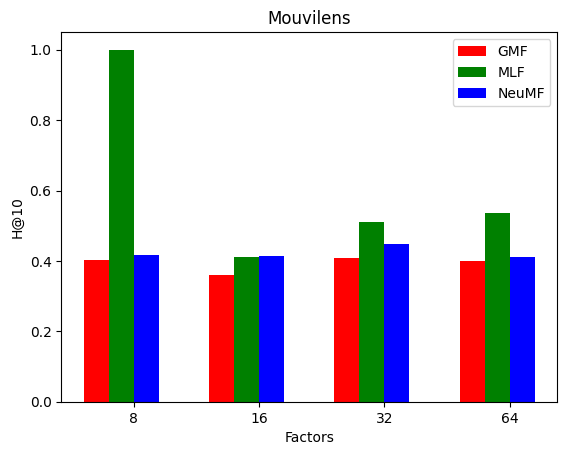

In [413]:
import numpy as np 
import matplotlib.pyplot as plt 

N = 4
ind = np.arange(N) 
width = 0.2
#for val in factors_scores_hr_GMF:
    

xvals = [] 
for val in factors_scores_hr_GMF:
    xvals.append(max(factors_scores_hr_GMF[val]))
print(xvals)
    
bar1 = plt.bar(ind, xvals, width, color='r') 

yvals = [] 
yvals = [max(factors_scores_hr_MLP_8),max(factors_scores_hr_MLP_16),max(factors_scores_hr_MLP_32),max(factors_scores_hr_MLP_64)] 
print(yvals)
bar2 = plt.bar(ind+width, yvals, width, color='g') 

zvals = []
for val in factors_scores_hr_NeuM:
    zvals.append(max(factors_scores_hr_NeuM[val]))
print(zvals)
bar3 = plt.bar(ind+width*2, zvals, width, color='b') 

plt.xlabel("Factors") 
plt.ylabel('H@10') 
plt.title("Mouvilens") 

plt.xticks(ind+width*1.5, ['8', '16', '32', '64'])
plt.legend((bar1, bar2, bar3), ('GMF', 'MLF', 'NeuMF')) 
plt.show()


[0.22518724133337265, 0.18775320250471977, 0.22091959533062341, 0.22279810037161626]
[0.36360394075110863, 0.2164143930609374, 0.2211787850568238, 0.2219475338552444]
[0.21644221093493216, 0.22654089692539767, 0.2472716425375847, 0.20661255938320944]


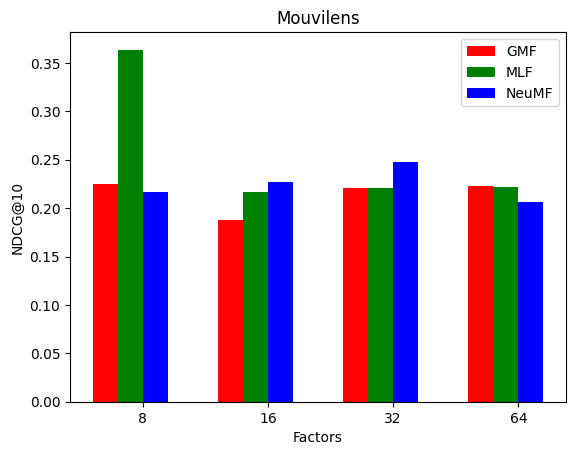

In [419]:
import numpy as np 
import matplotlib.pyplot as plt 

N = 4
ind = np.arange(N) 
width = 0.2
#for val in factors_scores_hr_GMF:
    

xvals = [] 
for val in factors_scores_hr_GMF:
    xvals.append(max(factors_scores_ndcg_gmf[val]))
print(xvals)
    
bar1 = plt.bar(ind, xvals, width, color='r') 
#""""""""""""""""""""""
yvals = [max(factors_scores_ndcg_MLP_8),max(factors_scores_ndcg_MLP_16),max(factors_scores_ndcg_MLP_32),max(factors_scores_ndcg_MLP_64)] 
print(yvals)
bar2 = plt.bar(ind+width, yvals, width, color='g') 
#########################""
zvals = []
for val in factors_scores_hr_NeuM:
    zvals.append(max(factors_scores_ndcg_NeurMF[val]))
print(zvals)
bar3 = plt.bar(ind+width*2, zvals, width, color='b') 

plt.xlabel("Factors") 
plt.ylabel('NDCG@10') 
plt.title("Mouvilens") 

plt.xticks(ind+width*1.5, ['8', '16', '32', '64'])
plt.legend((bar1, bar2, bar3), ('GMF', 'MLF', 'NeuMF')) 
plt.show()

In [225]:
dic={}
for i in [1,2,3,4]:
    dic[i]=i
print(dic)

{1: 1, 2: 2, 3: 3, 4: 4}


In [418]:

###############64

print(factors_scores_hr_MLP_64)
print(factors_scores_ndcg_MLP_64)

######## "32"
print(factors_scores_hr_MLP_32)

print(factors_scores_ndcg_MLP_32)


#trainin MLP for factor 16  


print(factors_scores_hr_MLP_16)

print(factors_scores_ndcg_MLP_16)


#trainin MLP for factor 8   
print(factors_scores_hr_MLP_8)

print(factors_scores_ndcg_MLP_8)

[0.39236479321314954, 0.40084835630965004]
[0.21801413906772873, 0.2219475338552444]
[0.39236479321314954, 0.4050901378579003]
[0.216655979457407, 0.2211787850568238]
[0.3806998939554613, 0.39236479321314954]
[0.20530630723214438, 0.2164143930609374]
[1.0, 0.9915164369034994]
[0.3568225817852297, 0.36360394075110863]
